# Windstorm selection helper

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [STORMS](https://github.com/CLIMAAX/STORMS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This notebook supports the [Hazard assessment for windstorms](Hazard_assessment_STORMS.ipynb): select storms based on proximity to a location of interest from the storm track database of the [historical storm](https://cds.climate.copernicus.eu/datasets/sis-european-wind-storm-indicators?tab=overview) dataset on CDS.


In [1]:
import pathlib
import io
import zipfile

import cdsapi
import earthkit.geo
import earthkit.plots
import numpy as np
import pandas as pd

## Preparation

Define the download folder:

In [2]:
data_dir = pathlib.Path("./STORM_event_raster")
data_dir.mkdir(parents=True, exist_ok=True)

# Where to download storm track dataset:
tracks_zip = data_dir / "windstorm_tracks.zip"

## Step 1: Download storm track data

Retrieve the windstorm tracks from CDS. See the [CDS user guide](https://cds.climate.copernicus.eu/user-guide) for more information on data access. Skip this step if the file is already available at the location specified in `tracks_zip`.

In [ ]:
URL = "https://cds.climate.copernicus.eu/api"
KEY = None  # put your key if required

client = cdsapi.Client(url=URL, key=KEY)

tracks_zip = client.retrieve("sis-european-wind-storm-indicators", {
    "product": ["windstorm_tracks"],
    "variable": "all"
}).download(tracks_zip)

## Step 2: Read storm track data

Define a class to represent a single storm,

In [3]:
class Storm:

    DATE_FORMAT = "%Y%m%d%H"

    DATA_COLS = [
        "time",
        "longitude_vo850", "latitude_vo850", "vo850",
        "longitude_mslp", "latitude_mslp", "mslp",
        "longitude_ws925", "latitude_ws925", "ws925",
        "longitude_ws10m", "latitude_ws10m", "ws10m",
        "longitude_ws925.3deg", "latitude_ws925.3deg", "ws925.3deg",
        "longitude_ws10m.3deg", "latitude_ws10m.3deg", "ws10m.3deg"
    ]

    def __init__(self, track_id, data, **attrs):
        self.track_id = track_id
        self.data = data
        self.name = attrs.pop("NAME", "-")
        self.attrs = attrs

    @classmethod
    def from_iter(cls, f):
        # First line: track ID and other attributes
        attrs = next(f).strip().split(" ")
        assert attrs[0] == "TRACK_ID"
        track_id = attrs[1]
        attrs = dict(zip(attrs[2::2], attrs[3::2]))
        # Second line: number of points in track
        line = next(f).strip()
        assert line.startswith("POINT_NUM ")
        n = int(line[10:])
        # Following n lines: track information (this is a bit messy, the delimiter
        # changes after the third column and not all columns are always present)
        data = []
        for _ in range(n):
            *values, other = next(f).strip().split(" ", 3)
            values.extend(other.split("&"))
            data.append(values)
        data = pd.DataFrame.from_records(data)
        data = data.where(data != "").dropna(axis=1)  # remove empty columns
        data.columns = cls.DATA_COLS[:data.columns.size]
        data["time"] = pd.to_datetime(data["time"], format=cls.DATE_FORMAT)
        data = data.set_index("time").astype(float)
        data = data.where(data < 1e25)
        # Longitudes in file are in [0°, 360°], adjust to [-180°, 180°] for convenience
        lon_cols = [col for col in data.columns if "longitude" in col]
        data[lon_cols] = ((data[lon_cols] + 180) % 360) - 180
        return cls(track_id, data, **attrs)

    def __repr__(self):
        return f"<Storm #{self.track_id} {self.name}>"

then parse the text representation of the tracks in the file:

In [4]:
def read_storms(f):
    storms = []
    while True:
        try:
            storms.append(Storm.from_iter(f))
        except StopIteration:
            break
    return storms


tracks_dat = "C3S_StormTracks_era5_19792021_0100_v1.dat"

with zipfile.ZipFile(tracks_zip) as archive:
    assert tracks_dat in archive.namelist()
    with archive.open("C3S_StormTracks_era5_19792021_0100_v1.dat", "r") as f:
        storms = read_storms(io.TextIOWrapper(f))

The first storms in the list:

In [5]:
storms[:3]

[<Storm #1 C3S_STORM_TRACKS_ERA5>,
 <Storm #2 C3S_STORM_TRACKS_ERA5>,
 <Storm #3 C3S_STORM_TRACKS_ERA5>]

## Step 3: Order storms by distance to location

Define the coordinates of your location of interest (`lat`, `lon`) and the reference variable with which to define the storm center (`ref`).
Choose from the following variables:

- `vo850`: position and magnitude of the relative vorticity maximum on the 850 hPa pressure level (a measure of the strength of rotation in the atmosphere in approx. 1.5 km height). Results in the smoothest and longest tracks. The `vo850` track coordinates provide the reference for the other variables.
- `mslp`: mean sea level pressure minimum within 5° of the vorticity centre.
- `ws925`: wind speed maximum on the 925 hPa level (approx. 900 m height) within 6° of the vorticity centre.
- `ws10m` wind speed maximum at 10m height above ground within 6° of the vorticity centre.
- `ws925.3deg`: same as `ws925` but within 3° of the vorticity centre. Not available for all tracks.
- `ws10m.3deg`: same as `ws10m` but within 3° of the vorticity centre. Not available for all tracks.

In [6]:
lat = 52.012  # °N
lon =  4.359  # °E

ref = "vo850"

Reorder the list of storms such that the geographically closest storms are at the top:

In [7]:
def minimum_distance(storm):
    """Shortest distance between the storm track and the location of interest"""
    track_lat = storm.data[f"latitude_{ref}"]
    track_lon = storm.data[f"longitude_{ref}"]
    dist = earthkit.geo.distance.haversine_distance(
        [lat, lon],
        [track_lat, track_lon]
    )
    return np.nanmin(dist)

# Reorder the list of storms
storms.sort(key=minimum_distance)

:::{admonition} Caveat
:class: warning

The strength of the storm along the track is not taken into account in the `minimum_distance` function implemented here, only the geographical distance between the chosen location and the storm center at its closest point. Other storm properties from the dataset can be accounted for by implementing a custom key function for `storms.sort`.
:::

The closest storms in the reordered list:

In [8]:
storms[:3]

[<Storm #30 WIEBKE>, <Storm #3 C3S_STORM_TRACKS_ERA5>, <Storm #89 XYNTHIA>]

## Step 4: Visualize tracks of closest storms

Display the tracks of the closest storms on a map together with the chosen location:

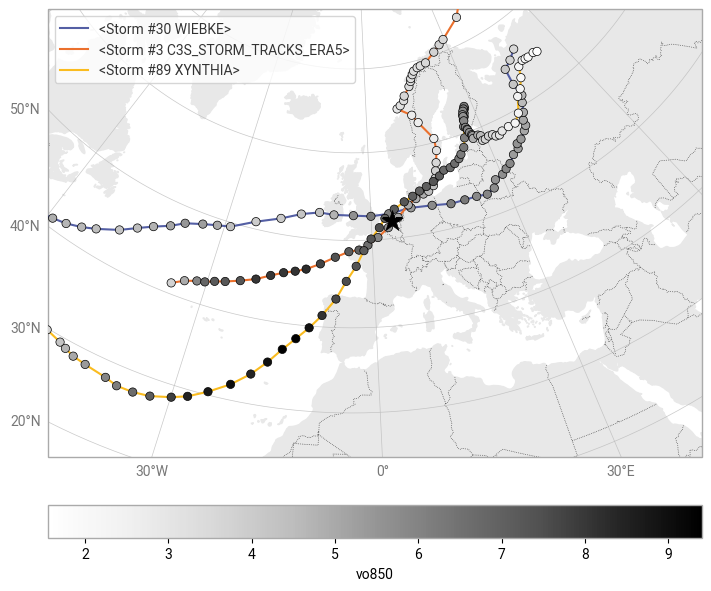

In [9]:
subplot = earthkit.plots.Map(domain=["North Atlantic", "Europe"])

# Marker for the location of interest
subplot.scatter(x=[lon], y=[lat], marker="*", c="black", s=250, zorder=10)

marker_x = []
marker_y = []
marker_c = []

# Number of storms to show
n = 3

for storm in storms[:n]:
    x = storm.data[f"longitude_{ref}"]
    y = storm.data[f"latitude_{ref}"]
    # Line for the track
    subplot.line(x=x, y=y, label=repr(storm), zorder=4)
    # Collect track information so storm strength markers can be plotted together
    # with a consistent colorscale
    marker_x.extend(x)
    marker_y.extend(y)
    marker_c.extend(storm.data[ref])

# Markers indicating the value of reference variable to represent storm strength
sc = subplot.scatter(x=marker_x, y=marker_y, c=marker_c, marker="o", cmap="Greys", zorder=5)

subplot.fig.colorbar(sc, label=f"{ref}", orientation="horizontal")
subplot.ax.legend()

subplot.land()
subplot.borders()
subplot.gridlines()

For all reference variables except `mslp`, higher values indicate a stronger storm.

## Step 5: Find the corresponding storm(s) on CDS

To download the gridded storm footprint for a storm based on the information from the tracks database, the date under which the gridded data has been filed on CDS must be found.
The data selection interface on the [CDS website](https://cds.climate.copernicus.eu/datasets/sis-european-wind-storm-indicators?tab=overview) can be used in the following way to find a matching date for a storm of interest: 
Take the date at which the storm is strongest along the track,

In [10]:
storms[0].data["vo850"].idxmax()

Timestamp('1990-02-24 12:00:00')

and select the year the storm falls into on the form on the CDS page.
After the selection of the year, the choices for month and day will be narrowed down in the form.
Find a valid month and day combination that most closely fits the date of the storm (this date may be up to two days before or after the one determined here).
Use this combination of year, month and day in the [Hazard assessment for windstorms](Hazard_assessment_STORMS.ipynb).

:::{note}

See the known issues in the [dataset documentation](https://cds.climate.copernicus.eu/datasets/sis-european-wind-storm-indicators?tab=documentation).
:::